# Joint LME models with surprisal and information value: Provo

In [28]:
### Import and utils
import ast
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ast import literal_eval
from pprint import pprint

# For local imports
import sys
sys.path.append('../../')
from utils import load_jsonl, load_surprise_data

# Plots
sns.set_palette('colorblind')
sns.set_style('white', {'font.family': 'Times New Roman'})
sns.set_context("paper", font_scale=2.5)

## Load data and preprocess

In [29]:
DATASETS = ['provo']

DATASET_CONTEXT_MAP = {
    'switchboard': 'switchboard/switchboard_results_is.jsonl',
    'dailydialog': 'dailydialog/dailydialog_results_is.jsonl',
    'BLL2018': 'BLL2018/processed_ratings.jsonl',
    'brown': 'RTs_5jun/brown_rt.jsonl',
    'ns': 'RTs_5jun/ns_rt.jsonl',
    'provo': 'RTs_5jun/provo_rt.jsonl',
}

CORPUS_NAMES = {
    'switchboard': 'Switchboard',
    'dailydialog': 'Dailydialog',
    'BLL2018': 'Clasp',
    'provo': 'Provo',
    'brown': 'Brown',
    'ns': 'Natural Stories',
}

MODEL_NAME_MAP = {
    'gpt2': 'GPT-2 Small',
    'gpt2-ft': 'GPT-2 Small Finetuned', # todo: remove
    'gpt2_medium': 'GPT-2 Medium',
    'gpt2-medium': 'GPT-2 Medium',
    'gpt2_large': 'GPT-2 Large',
    'gpt2-large': 'GPT-2 Large',
    'dialogpt_small': 'DialoGPT Small',
    'dialogpt-small': 'DialoGPT Small',
    'dialogpt_medium': 'DialoGPT Medium',
    'dialogpt-medium': 'DialoGPT Medium',
    'dialogpt_large': 'DialoGPT Large',
    'dialogpt-large': 'DialoGPT Large',
    'opt_125m': 'OPT 125M',
    'opt-125m': 'OPT 125M',
    'opt_350m': 'OPT 350M',
    'opt-350m': 'OPT 350M',
    'opt_1.3b': 'OPT 1.3B',
    'opt-1.3b': 'OPT 1.3B',
    'gpt_neo_125m': 'GPT-Neo 125M',
    'gpt-neo-125m': 'GPT-Neo 125M',
    'gpt_neo_1.3b': 'GPT-Neo 1.3B',
    'gpt-neo-1.3b': 'GPT-Neo 1.3B',
    'gpt-neo-1.3B': 'GPT-Neo 1.3B',
}

SAMPLING_PARAM_MAP = {
    "None": "None", "02": "0.2", "03": "0.3", "075": "0.75", "08": "0.8",
    "085": "0.85", "09": "0.9", "095": "0.95", "125": "1.25"
}

SURPRISAL_COLUMNS = [
    'in_context_surprisal', 'out_of_context_surprisal', 'in_context_surprisal_rnd',
       'in_context_entropies', 'out_of_context_entropies', 'in_context_entropies_rnd',
       'in_context_deviations', 'out_of_context_deviations', 'in_context_deviations_rnd',
]


In [30]:
### Load data

dfs = []
for dataset in DATASETS:
    print(f"Loading data for {dataset}...")
    DATA_DIR = f"../../../data/surprise/{dataset}"

    df = load_surprise_data(DATA_DIR)

    # Prettify column and value names
    df["corpus"] = df["corpus"].map(CORPUS_NAMES)
    df["sampling"] = df["sampling"].str.capitalize()
    df["sampling"] = df["sampling"].str.replace("Temp", "Temperature")

    df["model"] = df["model"].map(MODEL_NAME_MAP)

    sampling_param_map = {
        "None": "None", "02": "0.2", "03": "0.3", "075": "0.75", "08": "0.8",
        "085": "0.85", "09": "0.9", "095": "0.95", "125": "1.25"
    }
    df["sampling_param"] = df["sampling_param"].map(sampling_param_map)

    dfs.append(df)

surprise = pd.concat(dfs, axis=0, ignore_index=True)


Loading data for provo...
Size of dataset: 119680 rows


In [35]:
# Add sentence length to dataframe

# Add info about the stimuli (# tokens in context) -- COMMENT OUT
def _len(s):
    """
    Returns the length of a string or list of strings
    (dealing with different formats when we read json strings)
    """
    if not s:
        return 0
    assert(type(s) is str)
    return len(s.split())

mapping_len = {}
mapping_non_zero = {}
for dset in DATASETS:
    print(dset)
    # Load the context dataframe
    original_dataset = load_jsonl(f"../../../data/psychometric/{DATASET_CONTEXT_MAP[dset]}")
    df_original = pd.DataFrame(original_dataset)

    # # Deal with diff column names
    # if 'context_id' not in df_original.columns:
    #     df_original['context_id'] = df_original.id

    # Map context length based on (context_id, target_id)
    for _, row in df_original.iterrows():
        row_item_id = f"{row['text_id_']}_{row['sentence_num_']}"
        mapping_len[(row_item_id, CORPUS_NAMES[dset])] = _len(row['target'])
        mapping_non_zero[(row_item_id, CORPUS_NAMES[dset])] = row['time_count_nonzero_list_NO']

# Add the context_length column to df data
surprise['target_length'] = surprise.apply(
    lambda row: mapping_len.get((row['context_id'], row['corpus']), 0), axis=1
)
surprise['time_count_nonzero_list_NO'] = surprise.apply(
    lambda row: mapping_non_zero.get((row['context_id'], row['corpus']), 0), axis=1
)

provo


In [42]:
# Add info about the stimuli (# tokens in context)
mapping = {}
for dset in DATASETS:
    print(dset)
    # Load the context dataframe
    original_dataset = load_jsonl(f"../../../data/psychometric/RTs/provo_rt.jsonl")
    df_original = pd.DataFrame(original_dataset)
    
    # Deal with diff column names
    if 'context_id' not in df_original.columns:
        df_original['context_id'] = df_original.id

    # Map context length based on (context_id, target_id)
    mapping.update({
        (row['context_id'], CORPUS_NAMES[dset]): _len(row['context'])
        for _, row in df_original.iterrows()
    })


# Add the context_length column to df data
surprise['context_token_length'] = surprise.apply(lambda row: mapping.get((row['context_id'], row['corpus']), 0), axis=1)


provo


In [43]:
POWER_RANGE = np.arange(0.5, 5.01, 0.25)

def local_diff(x):
    """from RUID"""
    d = 0
    for i in range(len(x)-1):
        d += abs(x[i+1]-x[i])
    return d

def power(x, y):
    """from RUID"""
#     if x.mask.all():
#         return np.nan
#     return np.nanmean(x**y)
    return np.nansum(x**y)

def load_surprisal_data(data_dir, columns, surprisal_columns):
    """
    Load data from a directory of CSV files containing surprisal estimates.
    # Arguments:
        data_dir (str): Path to directory containing CSV files.
        columns (list): columns to load from CSV files. If None, all columns are loaded.
        surprisal_columns (list): columns to format with ast (ugly but fine for now)
    """
    data = None
    for file in os.listdir(data_dir):
        if file.endswith(".csv"):
            dset = data_dir.split('/')
            fp = os.path.join(data_dir, file)
            df = pd.read_csv(fp, usecols=columns)

            # Store with fields
            fields_from_name = fp.split('/')
            df['corpus'] = CORPUS_NAMES[fields_from_name[-2]]
            df['model'] = MODEL_NAME_MAP[fields_from_name[-1][:-4]]

            # literal eval
            for column in surprisal_columns:
                df[column] = df[column].apply(
                    lambda s: [
                        ast.literal_eval(x.strip(' []'))
                        for x in s.split() if x.strip(' []')
                    ]
                )

            if "data" in locals():
                data = pd.concat([data, df])
            else:
                data = df

    print(f"Size of dataset: {data.shape} rows, cols")

    # Add sequence surprisal aggregates
    surprise_cols = [c for c in data.columns if "in_" in c or "out_" in c]
    # print(surprise_cols)
    for col in surprise_cols:
        data[f'{col}_agg_sum'] = data[col].apply(np.sum)
        data[f'{col}_agg_variance'] = data[col].apply(np.var)
        data[f'{col}_agg_max'] = data[col].apply(np.amax)
        data[f'{col}_agg_mean'] = data[col].apply(np.mean)
        data[f'{col}_agg_ldiff'] = data[col].apply(local_diff)
        for p in POWER_RANGE:
            data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))

    print(f"Size of dataset: {data.shape} rows, cols")
    return data


In [44]:
cols = [
    'context_id',
]
all_cols = cols + SURPRISAL_COLUMNS

all_surprisal_dfs = []
for dataset in DATASETS:
    print(f"Loading data for {dataset}...")
    DATA_DIR = f"../../../data/surprisal/{dataset}"

    surprisal_df = load_surprisal_data(DATA_DIR, all_cols, SURPRISAL_COLUMNS)
    all_surprisal_dfs.append(surprisal_df)

surprisal = pd.concat(all_surprisal_dfs, axis=0, ignore_index=True)


Loading data for provo...
Size of dataset: (1088, 12) rows, cols


/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

Size of dataset: (1088, 228) rows, cols


/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{col}_agg_power_' + str(p).replace('.', '_')] = data[col].apply(lambda x: power(x, p))
/tmp/ipykernel_18682/2370563195.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [45]:
provo_one_df = surprise[
    (surprise['model'] == 'GPT-2 Small') &
    (surprise['corpus'] == 'Provo') &
    (surprise['sampling'] == 'Nucleus') &
    (surprise['sampling_param'] == '0.95') &
    (surprise['n_samples'] == 10)
]

provo_one_df_surprisal = surprisal[
    (surprisal['model'] == 'GPT-2 Small') &
    (surprisal['corpus'] == 'Provo')
]

for col in provo_one_df_surprisal.columns:
    if col not in provo_one_df.columns:
        provo_one_df[col] = provo_one_df_surprisal[col].tolist()

provo_one_df['mutual_info'] = provo_one_df['in_context_surprisal_agg_mean'] - provo_one_df['out_of_context_surprisal_agg_mean']


/tmp/ipykernel_18682/1826353571.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  provo_one_df[col] = provo_one_df_surprisal[col].tolist()
/tmp/ipykernel_18682/1826353571.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  provo_one_df[col] = provo_one_df_surprisal[col].tolist()
/tmp/ipykernel_18682/1826353571.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [46]:
print(len(provo_one_df), len(provo_one_df_surprisal))

# Let's only consider the relationship for stimuli that have contexts!
provo_one_df = provo_one_df[provo_one_df.context_token_length > 0]

print(len(provo_one_df), len(provo_one_df_surprisal))

136 136
82 136


In [47]:
# One row per judgement
provo_one_df['time_sum_list_NO'] = provo_one_df['time_sum_list_NO'].apply(literal_eval)
provo_one_df = provo_one_df.explode(['time_sum_list_NO', 'time_count_nonzero_list_NO']).reset_index(drop=True)
provo_one_df['time_sum_list_NO'] = pd.to_numeric(provo_one_df['time_sum_list_NO'])
provo_one_df['time_count_nonzero_list_NO'] = pd.to_numeric(provo_one_df['time_count_nonzero_list_NO'])


## Statistical models

In [48]:
from statsmodels.formula.api import mixedlm

def get_mixedlm_results(data_df, y, X, group, baseline_rdict=None, nan_policy='fill'):
    """
    Fit a mixed linear model with y as the response variable and X as the predictor variables.
    The model is fit with group as a random effect.

    :param data_df: Dataframe containing estimates and psychometric data
    :param y: Response variable (a string)
    :param X: Predictor variables (a list of strings)
    :param group: Group variable (a string)
    :param baseline_rdict: Dictionary containing results of a baseline model (as returned by this function)
    :param nan_policy: How to handle NaN values in the data. Either 'omit' or 'fill'.
    :return: Tuple containing the model results (a statsmodel object) and a dictionary of results
    """
    if nan_policy == 'omit':
        data_df = data_df.dropna(subset=X)
    elif nan_policy == 'fill':
        data_df = data_df.fillna(1.0)
    else:
        raise ValueError(f"Invalid nan_policy: {nan_policy}")

    formula = f"{y} ~ {' + '.join([x for x in ['1'] + X])}"

    model = mixedlm(
        formula,
        data_df,
        groups=data_df[group]
    )

    result = model.fit(method=["bfgs"])
    result_dict = {}

    tvals = result.tvalues.to_dict()
    for k in tvals:
        if k != "Group Var":
            result_dict[f"Coeff {k}"] = tvals[k]

    pvals = result.pvalues.to_dict()
    for k in pvals:
        if k != "Group Var":
            result_dict[f"p-value {k}"] = pvals[k]

    result_dict["Group Var"] = tvals["Group Var"]
    result_dict["Residual Var"] = result.scale
    result_dict["Total Var"] = result_dict["Residual Var"] + result_dict["Group Var"]
    result_dict["Explained Var"] = result_dict["Group Var"] / result_dict["Total Var"]
    result_dict["Log-Likelihood"] = result.llf
    result_dict["Converged"] = result.converged

    if baseline_rdict:
        result_dict["Delta Log-Likelihood"] = result_dict["Log-Likelihood"] - baseline_rdict["Log-Likelihood"]

    return result, result_dict

In [49]:
def get_single_predictor_results(single_predictor_models, to_latex=False):
    # First, get the coefficients, p-values, and deltas.
    coefficients = []
    p_values = []
    deltas = []
    _metrics = []
    for metric in single_predictor_models:
        _metrics.append(metric)
        coefficients.append(single_predictor_models[metric][f'Coeff {metric}'])
        p_values.append(single_predictor_models[metric][f'p-value {metric}'])
        deltas.append(single_predictor_models[metric]['Delta Log-Likelihood'])

    # Then, make a dataframe.
    single_predictor_df = pd.DataFrame({
        'Metric': _metrics,
        'Coefficient': coefficients,
        'Delta Log-Likelihood': deltas,
        'p-value': p_values,
    })

    # Round coefficients and deltas to 3 decimal places.
    single_predictor_df['Coefficient'] = single_predictor_df['Coefficient'].apply(lambda x: round(x, 3))
    single_predictor_df['Delta Log-Likelihood'] = single_predictor_df['Delta Log-Likelihood'].apply(lambda x: round(x, 3))

    # Make a latex table using coefficients, p-values, and deltas. Add a star to coefficient if p-value < 0.001.
    single_predictor_df['Coefficient'] = single_predictor_df.apply(lambda x: f"{x['Coefficient']}{'*' if x['p-value'] < 0.01 else ''}{'*' if x['p-value'] < 0.001 else ''}", axis=1)

    # print table without p-values, rounded to 3 decimal places
    if to_latex:
        print(single_predictor_df[['Metric', 'Coefficient', 'Delta Log-Likelihood']].to_latex(index=False, float_format="%.3f"))

    return single_predictor_df


In [50]:
def plot_single_predictor_results(single_predictor_df):
    fig, ax = plt.subplots(figsize=(13, 5))
    sns.barplot(
        data=pd.DataFrame({
            "Metric": single_predictor_df['Metric'],
            "Delta Log-Likelihood": single_predictor_df['Delta Log-Likelihood']
        }),
        x="Metric",
        y="Delta Log-Likelihood",
        ax=ax
    )

    ax.set_xlabel("")
    ax.set_ylabel("$\Delta$ Log-Likelihood")
    # rotate x tick labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

In [13]:
single_predictors_mixed = [
    'surprise_mean_1gram', 'surprise_mean_2gram', 'surprise_mean_3gram',
    'surprise_mean_1gram_pos', 'surprise_mean_2gram_pos', 'surprise_mean_3gram_pos',
    'surprise_mean_cosine', 'surprise_mean_euclidean',
    'surprise_min_1gram', 'surprise_min_2gram', 'surprise_min_3gram',
    'surprise_min_1gram_pos', 'surprise_min_2gram_pos', 'surprise_min_3gram_pos',
    'surprise_min_cosine', 'surprise_min_euclidean',
    'in_context_surprisal_agg_variance',
    'in_context_surprisal_agg_mean', 'in_context_surprisal_agg_max',
    'in_context_surprisal_agg_power_0_5', 'in_context_surprisal_agg_power_0_75',
    'out_of_context_surprisal_agg_sum', 'in_context_surprisal_agg_power_1_25',
    'in_context_surprisal_agg_power_1_5', 'in_context_surprisal_agg_power_1_75',
    'in_context_surprisal_agg_power_2_0', 'in_context_surprisal_agg_power_2_25',
    'in_context_surprisal_agg_power_2_5', 'in_context_surprisal_agg_power_2_75',
    'mutual_info'
]

response_var = "time_sum_list_NO"
control_predictors = ["time_count_nonzero_list_NO"]

-----

## Provo

### Baseline model

In [51]:
provo_baseline_result, provo_baseline_rdict = get_mixedlm_results(
    provo_one_df,
    y=response_var,
    X=control_predictors,
    group='context_id'
)
print(provo_baseline_result.summary())

                    Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      time_sum_list_NO
No. Observations:      6511         Method:                  REML            
No. Groups:            82           Scale:                   635622.4882     
Min. group size:       66           Log-Likelihood:          -52863.0892     
Max. group size:       84           Converged:               Yes             
Mean group size:       79.4                                                  
-----------------------------------------------------------------------------
                             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------------
Intercept                    -536.776   65.394 -8.208 0.000 -664.946 -408.605
time_count_nonzero_list_NO    330.611    3.607 91.650 0.000  323.541  337.681
Group Var                  188206.918   43.173                               



### Single predictor models

In [52]:
provo_single_predictor_models = {}
for metric in tqdm(single_predictors_mixed):
    _, tmp_rdict = get_mixedlm_results(
        provo_one_df,
        y=response_var,
        X=control_predictors + [metric],
        group='context_id',
        baseline_rdict=provo_baseline_rdict
    )
    provo_single_predictor_models[metric] = tmp_rdict


  0%|          | 0/30 [00:00<?, ?it/s]

In [53]:
provo_single_predictor_df = get_single_predictor_results(provo_single_predictor_models)

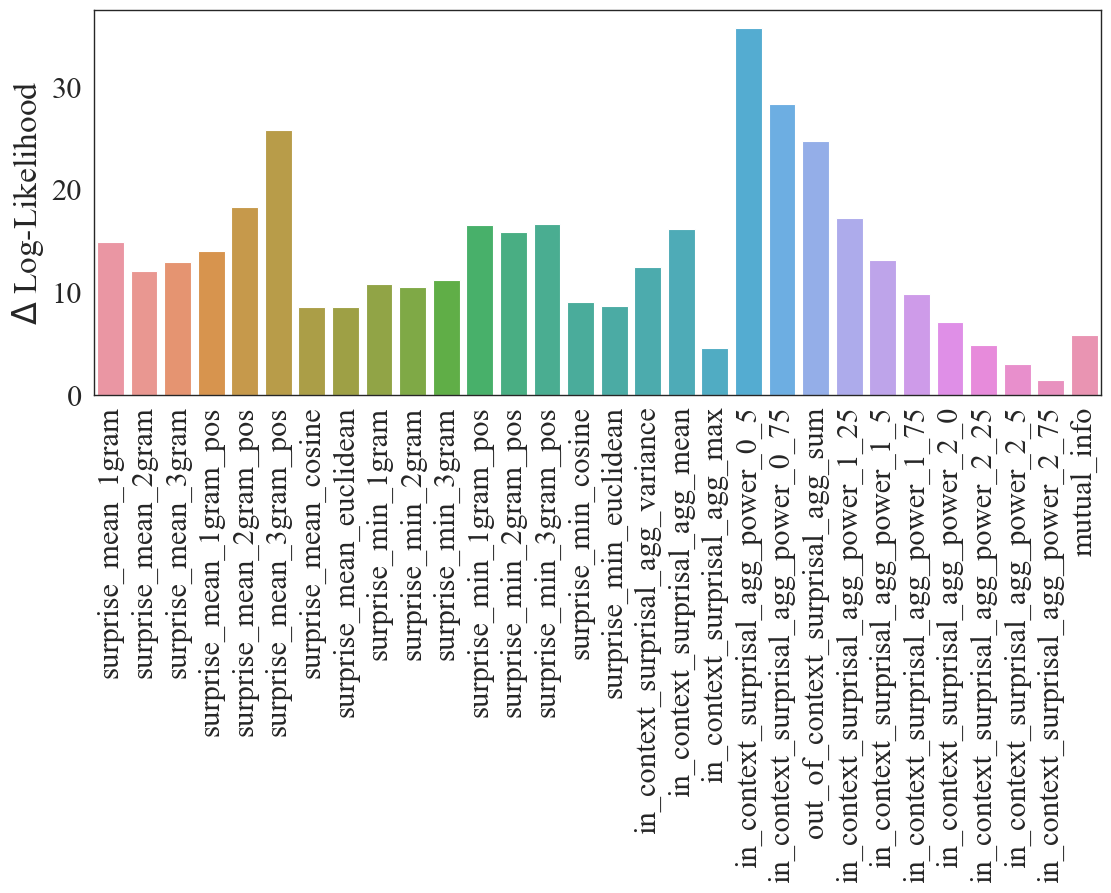

In [54]:
plot_single_predictor_results(provo_single_predictor_df)

In [55]:
best_surprisal = provo_single_predictor_df[
    provo_single_predictor_df.Metric.str.contains("surprisal")
].sort_values('Delta Log-Likelihood', ascending=False).head(3)

best_surprisal

,Metric,Coefficient,Delta Log-Likelihood,p-value
19,in_context_surprisal_agg_power_0_5,-9.4**,35.747,5.471479e-21
20,in_context_surprisal_agg_power_0_75,-8.078**,28.323,6.578677e-16
21,out_of_context_surprisal_agg_sum,-7.476**,24.756,7.646202e-14


In [56]:
provo_single_predictor_df[
    ~provo_single_predictor_df.Metric.str.contains("surprisal")
].sort_values('Delta Log-Likelihood', ascending=False).head(6)

,Metric,Coefficient,Delta Log-Likelihood,p-value
5,surprise_mean_3gram_pos,6.487**,25.864,8.732472e-11
4,surprise_mean_2gram_pos,4.939**,18.307,7.861310e-07
13,surprise_min_3gram_pos,4.588**,16.688,4.471399e-06
11,surprise_min_1gram_pos,4.432**,16.514,9.319632e-06
12,surprise_min_2gram_pos,4.379**,15.841,1.194925e-05
0,surprise_mean_1gram,3.934**,14.934,8.363656e-05


### Joint models

In [57]:
provo_surprisal_baseline_result, provo_surprisal_baseline_rdict = get_mixedlm_results(
    provo_one_df,
    y=response_var,
    X=control_predictors + ['in_context_surprisal_agg_power_0_5'],
    group='context_id',
)
print(provo_surprisal_baseline_result.summary())

                      Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       time_sum_list_NO
No. Observations:         6511          Method:                   REML            
No. Groups:               82            Scale:                    634871.8609     
Min. group size:          66            Log-Likelihood:           -52827.3421     
Max. group size:          84            Converged:                Yes             
Mean group size:          79.4                                                    
----------------------------------------------------------------------------------
                                     Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                            187.564   82.835  2.264 0.024  25.209 349.918
time_count_nonzero_list_NO           337.583    3.484 96.889 0.000 330.754 344.412
in_context_surprisal_agg_po

In [58]:
provo_joint_result, provo_joint_rdict = get_mixedlm_results(
    provo_one_df,
    y=response_var,
    X=control_predictors + ['in_context_surprisal_agg_power_0_5', 'surprise_min_1gram_pos', 'surprise_min_2gram_pos', 'surprise_mean_3gram_pos'],
    group='context_id',
    baseline_rdict=provo_surprisal_baseline_rdict
)
pprint(provo_joint_rdict)

{'Coeff Intercept': -2.9514466601112006,
 'Coeff in_context_surprisal_agg_power_0_5': -6.877451545680396,
 'Coeff surprise_mean_3gram_pos': 2.7724422665943607,
 'Coeff surprise_min_1gram_pos': -0.8881177345630167,
 'Coeff surprise_min_2gram_pos': -0.2442217455199687,
 'Coeff time_count_nonzero_list_NO': 97.08196349486713,
 'Converged': True,
 'Delta Log-Likelihood': 28.38059140243422,
 'Explained Var': 8.678671191842083e-06,
 'Group Var': 5.509832454098763,
 'Log-Likelihood': -52798.96150343884,
 'Residual Var': 634865.0057457815,
 'Total Var': 634870.5155782356,
 'p-value Intercept': 0.0031628916976237068,
 'p-value in_context_surprisal_agg_power_0_5': 6.093273775172749e-12,
 'p-value surprise_mean_3gram_pos': 0.005563738775126266,
 'p-value surprise_min_1gram_pos': 0.3744774239811255,
 'p-value surprise_min_2gram_pos': 0.8070590863928525,
 'p-value time_count_nonzero_list_NO': 0.0}


## Context Condition Comparison
### With all individual predictors

In [59]:
provo_baseline_result, provo_baseline_rdict = get_mixedlm_results(
    provo_one_df,
    y=response_var,
    X=control_predictors,
    group='context_id'
)
print(provo_baseline_result.summary())


                    Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      time_sum_list_NO
No. Observations:      6511         Method:                  REML            
No. Groups:            82           Scale:                   635622.4882     
Min. group size:       66           Log-Likelihood:          -52863.0892     
Max. group size:       84           Converged:               Yes             
Mean group size:       79.4                                                  
-----------------------------------------------------------------------------
                             Coef.    Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------------------
Intercept                    -536.776   65.394 -8.208 0.000 -664.946 -408.605
time_count_nonzero_list_NO    330.611    3.607 91.650 0.000  323.541  337.681
Group Var                  188206.918   43.173                               



In [60]:
# Select the best distances from sec 6
measures_df = pd.read_csv('../analysis_sec6/dataframes/provo_measures.csv')
# Either by measure
top_measure = measures_df[measures_df['Delta Log-Likelihood'] == np.max(measures_df['Delta Log-Likelihood'])]
top_distances = ast.literal_eval(list(top_measure['Distances'])[0])

# Or by most predictive features (ie, best distances for surprisal)
surprise_measure = measures_df[measures_df['Measure'] == 'surprise']
surprise_distances = ast.literal_eval(list(surprise_measure['Distances'])[0])

measures_df[['Delta Log-Likelihood', 'Measure', 'Distances']].sort_values(by='Delta Log-Likelihood', ascending=False)

# Select the best surprisal
surprisals = list(best_surprisal['Metric'])
surprise_distances + surprisals


['surprise_mean_3gram_pos',
 'surprise_mean_3gram',
 'surprise_mean_euclidean',
 'in_context_surprisal_agg_power_0_5',
 'in_context_surprisal_agg_power_0_75',
 'out_of_context_surprisal_agg_sum']

In [70]:
# ['in_context_surprisal_' + '_'.join(s.split('_')[s.split('_').index('surprisal') + 1:]) for s in surprisals]
# ['surprise_' + '_'.join(s.split('_')[s.split('_').index('surprise') + 1:]) for s in surprise_distances]


['agg_power_0_5', 'agg_power_0_75', 'agg_sum']

In [71]:
mean_surprise_deltas = {}
for metric in tqdm(surprise_distances + surprisals):
    _, tmp_mean_surprise_rdict = get_mixedlm_results(
        provo_one_df,
        y=response_var,
        X=control_predictors + [metric],
        group='context_id',
        baseline_rdict=provo_baseline_rdict
    )
    mean_surprise_deltas[metric] = tmp_mean_surprise_rdict["Delta Log-Likelihood"]
    
# Compare these results to OOC logliks
mean_ooc_surprise_deltas = {}
for metric in tqdm(
    ['surprise_ooc_' + '_'.join(s.split('_')[s.split('_').index('surprise') + 1:]) for s in surprise_distances] + 
    ['out_of_context_surprisal_' + '_'.join(s.split('_')[s.split('_').index('surprisal') + 1:]) for s in surprisals]
#     ['surprise_ooc_' + "_".join(s.split("_")[1:]) for s in surprise_distances] + 
#     ['out_of_' + "_".join(s.split("_")[1:]) for s in surprisals]
                  ):
    # print(metric)
    _, tmp_mean_surprise_rdict = get_mixedlm_results(
        provo_one_df,
        y=response_var,
        X=control_predictors + [metric],
        group='context_id',
        baseline_rdict=provo_baseline_rdict
    )
    mean_ooc_surprise_deltas[metric] = tmp_mean_surprise_rdict["Delta Log-Likelihood"]

# Compare these results to random logliks
mean_rnd_surprise_deltas = {}
for metric in tqdm(
    ['surprise_rnd_' + '_'.join(s.split('_')[s.split('_').index('surprise') + 1:]) for s in surprise_distances] + 
    ['in_context_surprisal_rnd_' + '_'.join(s.split('_')[s.split('_').index('surprisal') + 1:]) for s in surprisals]
#     ['surprise_rnd_' + "_".join(s.split("_")[1:]) for s in surprise_distances] + 
#     ['in_context_surprisal_rnd_' + "_".join(s.split("_")[3:]) for s in surprisals]
                  ):
    # print(metric)
    _, tmp_mean_surprise_rdict = get_mixedlm_results(
        provo_one_df,
        y=response_var,
        X=control_predictors + [metric],
        group='context_id',
        baseline_rdict=provo_baseline_rdict
    )
    mean_rnd_surprise_deltas[metric] = tmp_mean_surprise_rdict["Delta Log-Likelihood"]
    

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

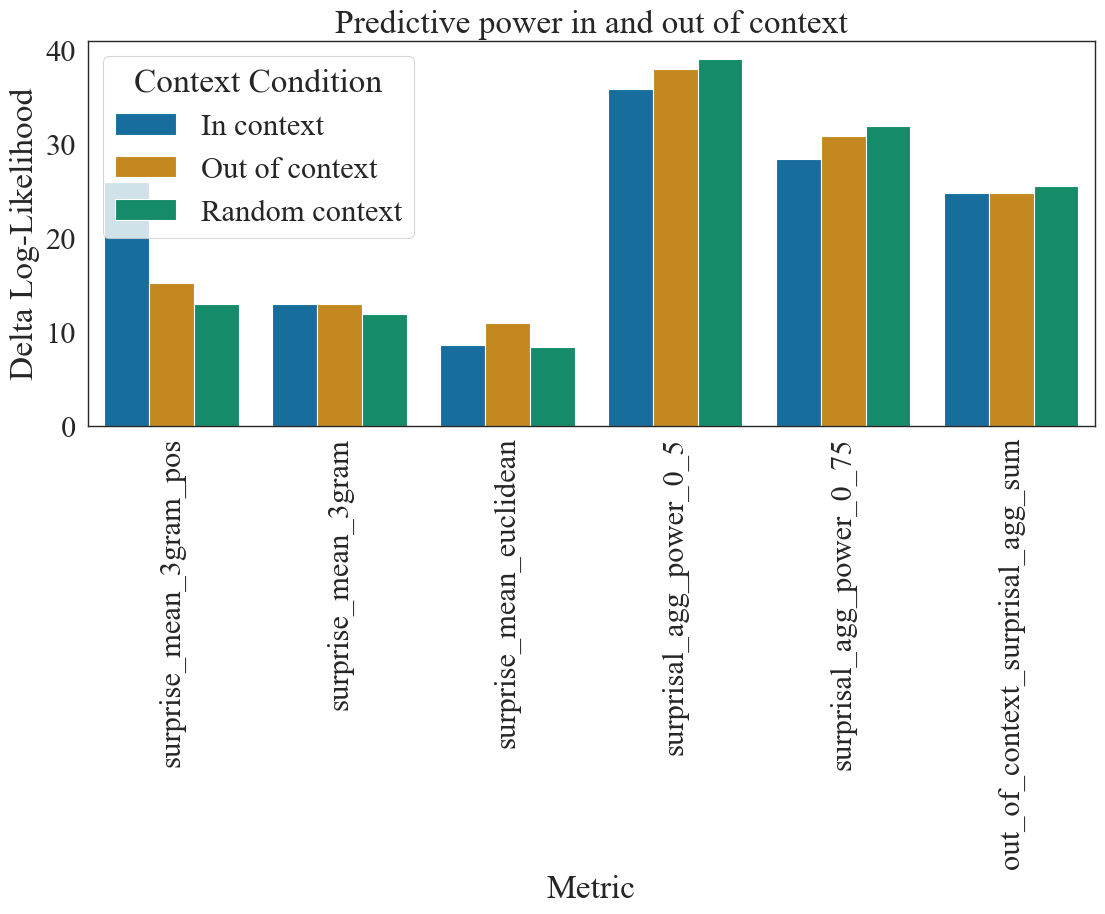

In [72]:
print_cols = [c[11:] if c[0] == 'i' else c for c in list(mean_surprise_deltas.keys())]

df = pd.DataFrame({
#     "Metric": list(mean_surprise_deltas.keys()),
    "Metric": print_cols,
    "In context": list(mean_surprise_deltas.values()),
    "Out of context": list(mean_ooc_surprise_deltas.values()),
    "Random context": list(mean_rnd_surprise_deltas.values()),
})

df_melted = df.melt(id_vars="Metric", var_name="Context Condition", value_name="Delta Log-Likelihood")


fig, ax = plt.subplots(figsize=(13, 5))
bp = sns.barplot(data=df_melted, 
            x="Metric", 
            y="Delta Log-Likelihood", 
            hue="Context Condition", 
            ax=ax)
bp.set_xticklabels(
    bp.get_xticklabels(), 
    rotation=90, 
)

plt.xlabel("Metric")
plt.ylabel("Delta Log-Likelihood")
plt.title("Predictive power in and out of context")

plt.legend(title="Context Condition")
plt.show()
    


In [85]:
# df_melted = df.melt(id_vars="Context Condition", var_name="Metric", value_name="Delta Log-Likelihood")

In [81]:
print(df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lrrr}
\toprule
Metric & In context & Out of context & Random context \\
\midrule
surprise_mean_3gram_pos & 25.864 & 15.200 & 12.943 \\
surprise_mean_3gram & 12.972 & 12.942 & 11.859 \\
surprise_mean_euclidean & 8.533 & 10.882 & 8.325 \\
surprisal_agg_power_0_5 & 35.747 & 37.877 & 39.002 \\
surprisal_agg_power_0_75 & 28.323 & 30.826 & 31.907 \\
out_of_context_surprisal_agg_sum & 24.756 & 24.756 & 25.502 \\
\bottomrule
\end{tabular}



In [88]:

CONTEXT_CONDS = ['In context', 'Out of context']
FEATURES = ['Syntactic', 'Lexical', 'Semantic']

def feature_type(x):
    if 'pos' in x:
        return FEATURES[0]
    elif 'gram' in x:
        return FEATURES[1]
    else:
        return FEATURES[2]

df['Context Condition'] = df['Metric'].apply(lambda x : CONTEXT_CONDS[1] if 'ooc' in x else CONTEXT_CONDS[0])
df['Feature Type'] = df['Metric'].apply(lambda x : feature_type(x))

print(df[['Feature Type', 'Metric', 'In context', 'Out of context', 'Random context']].to_latex(
    index=False, 
    float_format="%.3f"))



\begin{tabular}{llrrr}
\toprule
Feature Type & Metric & In context & Out of context & Random context \\
\midrule
Syntactic & surprise_mean_3gram_pos & 25.864 & 15.200 & 12.943 \\
Lexical & surprise_mean_3gram & 12.972 & 12.942 & 11.859 \\
Semantic & surprise_mean_euclidean & 8.533 & 10.882 & 8.325 \\
Semantic & surprisal_agg_power_0_5 & 35.747 & 37.877 & 39.002 \\
Semantic & surprisal_agg_power_0_75 & 28.323 & 30.826 & 31.907 \\
Semantic & out_of_context_surprisal_agg_sum & 24.756 & 24.756 & 25.502 \\
\bottomrule
\end{tabular}

